# <u> Bounding Box Regressor</u>

## [1] Get details of the instance.

In [ ]:
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

* If you don't get enough RAM (or) get an error, then reset the runtime.

In [ ]:
# Link the Google drive to use the dataset
#from google.colab import drive
#drive.mount('/content/drive')

<u><b>Note:</b></u>

* If you try to run this on your system or any other place like google colaboratory, then please specify proper paths.

## [2] Data preprocessing

In [ ]:
### This is a one time step
# Convert all the images in train and test data to grayscale images


In [151]:
# Importing necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential, Model
from keras.layers import Input,Dense,  BatchNormalization, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D , Conv2D
from keras import losses
from matplotlib.patches import Rectangle
from keras.callbacks import EarlyStopping
import os
import random
from PIL import Image
import keras.backend as K
from tqdm import tqdm
import pickle


In [152]:
## Backend Framework Used
print(K.name_scope)

<class 'tensorflow.python.framework.ops.name_scope'>


In [194]:
current_path = !pwd
# Set the train_dir path properly
train_dir = os.path.join('data','train')
train_img_dir = os.path.join(train_dir,'images')
train_csv = os.path.join(train_dir,'training.csv')
train = pd.read_csv(train_csv)

# set size as per your compute power
size = 8000
train = train.iloc[random.sample(range(train.shape[0]),size)].copy()


tr_size = int(train.shape[0]*0.6)
cv_size = int(train.shape[0]*0.2)
te_size = int(train.shape[0]*0.2)

tr_indices = range(tr_size)
cv_indices = range(tr_size,tr_size+cv_size)
te_indices = range(tr_size+cv_size,tr_size+cv_size+te_size)

test = train.iloc[cv_indices].copy()
cv = train.iloc[te_indices].copy()
train = train.iloc[tr_indices].copy()

cv_dir = os.path.join('data','train')
cv_img_dir = os.path.join(cv_dir,'images')

test_dir = os.path.join('data','train')
test_img_dir = os.path.join(test_dir,'images')

In [195]:
print(train.shape)
print(cv.shape)
print(test.shape)

(4800, 5)
(1600, 5)
(1600, 5)


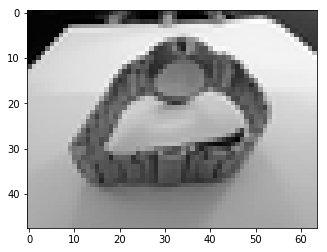

The shape of image is:(48, 64)
The maximum and minimum value of each cell in an image is 249.039, 0.0


In [196]:
#getting random image from dataset and converting it to gray scale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Resizing Image because it will be hard to compute covariance matrix later
thumbnail_shape = (64,64)
rows = train.shape[0]
temp = train.iloc[random.randint(0,rows-1)] 
img = Image.open(os.path.join(train_img_dir,temp['image_name']))
img.thumbnail(thumbnail_shape, Image.ANTIALIAS)# resizes image in-place
img =  rgb2gray(np.array(img))
plt.imshow(img,cmap='gray')
plt.show()
img = np.array(img)
img_shape  = img.shape
print("The shape of image is:"+str(img_shape))
print("The maximum and minimum value of each cell in an image is "+str(img.max())+", "+str(img.min()))

* *Images are in channel-last format.*
* *Images are already normalized.*

In [197]:
### Central Limit Theorem to find the mean and variance of the population images
number_of_samples = 30
sample_size = 30
means = list()
for i in range(number_of_samples):
    random.seed(i)
    sample = random.sample(range(0,tr_size-1),sample_size)
    imgs = list()
    for _ in sample:
        img_name = train.image_name.iloc[_]
        img = Image.open(os.path.join(train_img_dir,img_name))
        img.thumbnail(thumbnail_shape, Image.ANTIALIAS)
        img =  rgb2gray(np.array(img))
        imgs.append(img)  
    imgs=np.array(imgs)
    means.append(np.mean(imgs,axis = 0))
means = np.array(means)

# Population mean and variance 
mean = np.mean(means,axis=0)
variance = np.var(means, axis = 0) * sample_size

del means #deleting sample means array
del imgs # deleting sample images array

In [200]:
# Getting sample images to compute zca matrix
sample_imgs = list()
random.seed(1234)
sample_size = 500 #Change this as per your convinience
sample = random.sample(range(0,tr_size-1),sample_size)

for i in tqdm(sample):
    img_name = train.image_name.iloc[i]
    img = Image.open(os.path.join(train_img_dir,img_name))
    img.thumbnail(thumbnail_shape, Image.ANTIALIAS)
    img =  rgb2gray(np.array(img))
    sample_imgs.append(img)
sample_imgs = np.array(sample_imgs)

100%|██████████| 500/500 [00:17<00:00, 29.02it/s]


In [201]:
# Normalising sample data
sample_imgs = sample_imgs - mean
sample_imgs = sample_imgs/variance

In [202]:
sample_imgs.shape

(500, 48, 64)

In [203]:
# Reshaping the image data to perform covariance

from functools import reduce
pres_shape = sample_imgs.shape
dim1 = sample_imgs.shape[0]
dim2 = int(reduce(lambda x,y: x*y, sample_imgs.shape) / dim1)
sample_imgs = sample_imgs.reshape(dim1,dim2)
print (sample_imgs.shape)

(500, 3072)


In [204]:
def center(X):
    newX = X - mean
    return newX

def decorrelate(X):
    X = center(X)
    cov = np.cov(X, rowvar=False)
    eigVals, eigVecs = np.linalg.eig(cov)
    decorrelated = X.dot(eigVecs)
    return decorrelated

def zca_whitening_matrix(X):
    sigma = np.cov(X, rowvar=False) 
    U,S,V = np.linalg.svd(sigma)
    epsilon = 1e-5
    ZCAMatrix = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T)
    return ZCAMatrix

In [205]:
sample_imgs = np.nan_to_num(sample_imgs)
zca_mat = zca_whitening_matrix(sample_imgs)

In [207]:
mod_samp_imgs = sample_imgs.dot(zca_mat)

mod_samp_imgs = mod_samp_imgs.reshape(pres_shape)
sample_imgs = sample_imgs.reshape(pres_shape)

mod_samp_imgs = (mod_samp_imgs - mod_samp_imgs.min()) / (mod_samp_imgs.max() - mod_samp_imgs.min())

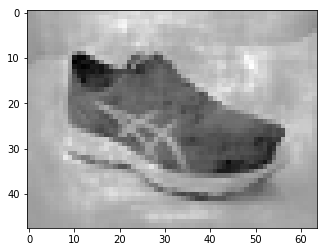

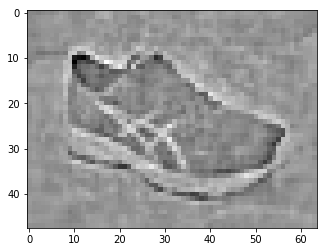

In [208]:
# original image
plt.imshow(sample_imgs[0],cmap="gray")
plt.show()

#Whitened image
plt.imshow(mod_samp_imgs[0],cmap="gray")
plt.show()

In [ ]:
mean = mean[:,:,np.newaxis]
variance = variance[:,:,np.newaxis]

## [3] Defining CNN architecture.

In [187]:
learning_rate = 0.01
input_shape = (48, 64,1)

model = Sequential()
model.add(Conv2D(32, (7, 7), activation='relu',input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
model.add(Conv2D(32, (9, 9), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(output_dim = 4, activation='relu',name = "output-1"))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 42, 58, 32)        1600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 29, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 21, 32)        82976     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 10, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 10, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 10, 32)         128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
__________

/home/sanjeeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", name="output-1", units=4)`
  


In [262]:
def batch_training(train,cv,callback,epochs=3,sample_size = 100, step_save=1,batch_size=32,optimizer='Adam',folder_name="model"):
    model.compile(optimizer='Adam', loss=losses.mean_absolute_error, metrics = ['mean_absolute_error'])
    !mkdir models
    !mkdir models/$folder_name
    
    
    #required
    x = list()
    vy= list()
    ty = list()
    fig,ax = plt.subplots(1,1)
    for _ in range(epochs):
        # Get random subset of data for both train and cv  for each epoch
        random.seed(i)
        sample = random.sample(range(0,tr_size-1),sample_size)
        imgs_tr = list()
        y_tr = list()
        for k in sample:
            img_name = train.image_name.iloc[i]
            img = Image.open(os.path.join(train_img_dir,img_name))
            img.thumbnail(thumbnail_shape, Image.ANTIALIAS)
            img =  rgb2gray(np.array(img))
            imgs_tr.append(img)
            y_tr.append(np.array([train.x1.iloc[k],train.x2.iloc[k],train.y1.iloc[k],train.y2.iloc[k]]))
        imgs_tr=np.array(imgs_tr)
        imgs_tr = imgs_tr[:,:,:,np.newaxis]
        y_tr = np.array(y_tr)
        
        sample = random.sample(range(0,cv_size-1),sample_size)
        imgs_cv = list()
        y_cv = list()
        for k in sample:
            img_name = train.image_name.iloc[i]
            img = Image.open(os.path.join(train_img_dir,img_name))
            img.thumbnail(thumbnail_shape, Image.ANTIALIAS)
            img =  rgb2gray(np.array(img))
            imgs_cv.append(img)  
            y_cv.append(np.array([train.x1.iloc[k],train.x2.iloc[k],train.y1.iloc[k],train.y2.iloc[k]]))
        imgs_cv=np.array(imgs_cv)
        imgs_cv = imgs_cv[:,:,:,np.newaxis]
        y_cv = np.array(y_cv)
        
        
        ### Preprocess them
        # Normalising the train and cv data and multipling with zca matrix
        imgs_tr = imgs_tr - mean
        imgs_tr = imgs_tr / variance
        
        pres_shape = imgs_tr.shape
        dim1 = imgs_tr.shape[0]
        dim2 = int(reduce(lambda x,y: x*y, imgs_tr.shape) / dim1)
        imgs_tr = imgs_tr.reshape(dim1,dim2)
        imgs_tr = imgs_tr.dot(zca_mat)
        imgs_tr = imgs_tr.reshape(pres_shape)
        imgs_tr = (imgs_tr - imgs_tr.min()) / (imgs_tr.max() - imgs_tr.min())
        
        imgs_cv = imgs_cv - mean
        imgs_cv = imgs_cv / variance
        pres_shape = imgs_cv.shape
        dim1 = imgs_cv.shape[0]
        dim2 = int(reduce(lambda x,y: x*y, imgs_cv.shape) / dim1)
        imgs_cv = imgs_cv.reshape(dim1,dim2)
        imgs_cv = imgs_cv.dot(zca_mat)
        imgs_cv = imgs_cv.reshape(pres_shape)
        imgs_cv = (imgs_cv - imgs_cv.min()) / (imgs_cv.max() - imgs_cv.min())
        
        
        ## Epoch starts
        print("*"*10+"EPOCH_"+str(_+1)+"*"*10)
        history = model.fit(imgs_tr,y_tr,
              epochs=1, batch_size=batch_size,validation_data = (imgs_cv,y_cv),
              callbacks = callback,verbose = 0)
        
        ax.set_xlabel('epoch') ; ax.set_ylabel('Mean Absolute Loss')
        # list of epoch numbers
        print("Train Loss:"+str(history.history['loss'][0]))
        print("Validation Loss:"+str(history.history['val_loss'][0]))
        x.append(_+1)
        vy.extend( history.history['val_loss'])
        ty.extend( history.history['loss'])
        #plt_dynamic(x, vy, ty, ax,fig)
        ax.plot(x, vy, 'b', label="Validation Loss")
        ax.plot(x, ty, 'r', label="Train Loss")
        plt.grid()
        fig.canvas.draw()
        
        
        if _ % step_save==0:
            model.save("models/"+folder_name+"/"+str(_)+".h5")
            model.save_weights("models/"+folder_name+"/"+str(_)+".w5")
    pass

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘models/sample_model’: File exists
**********EPOCH_1**********
Train Loss:278.69855224609375
Validation Loss:278.6582647705078
**********EPOCH_2**********
Train Loss:277.66679443359374
Validation Loss:277.52079406738284
**********EPOCH_3**********
Train Loss:274.30810302734375
Validation Loss:273.67146728515627
**********EPOCH_4**********
Train Loss:269.54497314453124
Validation Loss:267.551611328125
**********EPOCH_5**********
Train Loss:263.78240478515625
Validation Loss:260.1827142333984


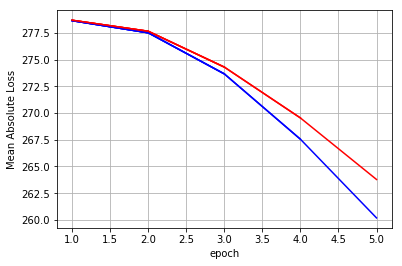

In [263]:
callback = [EarlyStopping(monitor='val_loss', patience=15, verbose=0),]
model_folder_name = 'sample_model' #Change this every time to save your models in different folders.
batch_training(train,cv,callback,sample_size = 1000, epochs=5,batch_size=16,folder_name=model_folder_name)

### [4]Loading and Testing

In [22]:
from keras.models import load_model
model_folder_name = 'model1'
best_model = 40
model = load_model("models/"+model_folder_name+"/"+str(best_model)+".h5")
model.load_weights("models/"+model_folder_name+"/"+str(best_model)+".w5")

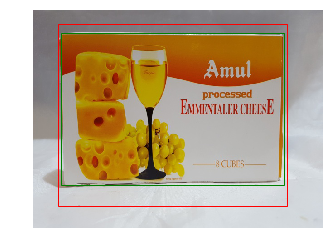

IoU is0.8137054845712709


In [27]:
#getting random image from dataset
rows = train.shape[0]
temp = train.iloc[random.randint(0,rows-1)] 
img = mpimg.imread(os.path.join(train_img_dir,temp['image_name']))

axs = plt.imshow(img)

##drawing bounding box
x1,x2,y1,y2 = temp['x1'],temp['x2'],temp['y1'],temp['y2']
rect = Rectangle((x1,y2),(x2-x1),(y1-y2),linewidth=1,edgecolor='g',facecolor='none')
# Add the patch to the Axes
axs.axes.add_patch(rect)
true=dict()
true['x1'],true['x2'],true['y1'],true['y2']=x1,x2,y1,y2


x1,x2,y1,y2 = model.predict(np.expand_dims(img, axis=0))
rect = Rectangle((x1,y2),(x2-x1),(y1-y2),linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
axs.axes.add_patch(rect)
pred=dict()
pred['x1'],pred['x2'],pred['y1'],pred['y2']=x1,x2,y1,y2 

plt.axis('off')
plt.show()

print("IoU is"+str(get_iou(true,pred)))

In [219]:

# https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
def iou_metric(y_true,y_pred):
    true = dict()
    pred = dict()
    true['x1'] = y_true[0]
    true['x2'] = y_true[1]
    true['y1'] = y_true[2]
    true['y2'] = y_true[3]
    pred['x1'] = y_pred[0][0]
    pred['x2'] = y_pred[0][1]
    pred['y1'] = y_pred[0][2]
    pred['y2'] = y_pred[0][3]
    return get_iou(true,pred)